<a href="https://colab.research.google.com/github/lkhok22/ML-FinalProject-Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_N_BEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install kaggle wandb torch pandas numpy scikit-learn matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc  # For garbage collection
from sklearn.base import BaseEstimator, TransformerMixin

# Initialize wandb
import wandb
wandb.init(project="walmart-sales-forecasting", name="nbeats-run")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# Suppress warnings
warnings.filterwarnings('ignore')

# Log initialization completion
wandb.log({"step": "initialization", "status": "completed"})
print("Initialization and package installation completed.")

  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lkhok22 (lkhok22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initialization and package installation completed.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip and load data
import zipfile
import glob
zip_path = "/content/drive/MyDrive/ML-FinalProject/data.zip"
extract_path = "/content/data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
for zip_file in glob.glob(f"{extract_path}/*.csv.zip"):
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall(extract_path)

# Load datasets
stores = pd.read_csv(f"{extract_path}/stores.csv")
train = pd.read_csv(f"{extract_path}/train.csv")
features = pd.read_csv(f"{extract_path}/features.csv")
test = pd.read_csv(f"{extract_path}/test.csv")
sample = pd.read_csv(f"{extract_path}/sampleSubmission.csv")

# Convert 'Date' columns to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge datasets
train_df = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_df = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how='left')
train_df = pd.merge(train_df, stores, on='Store', how='left')
test_df = pd.merge(test_df, stores, on='Store', how='left')

# Log data loading stats
wandb.log({
    "step": "data_loading",
    "status": "completed",
    "train_rows": len(train_df),
    "test_rows": len(test_df),
    "stores_count": len(stores),
    "features_count": len(features)
})
print(f"Data loaded successfully. Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# Free up memory
del train, test, features, stores
gc.collect()

Mounted at /content/drive
Data loaded successfully. Train shape: (421570, 16), Test shape: (115064, 15)


384

In [3]:
# Define preprocessing classes
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, markdown_cols=None, numerical_cols_to_impute=None):
        self.markdown_cols = markdown_cols if markdown_cols is not None else [f'MarkDown{i}' for i in range(1, 6)]
        self.numerical_cols_to_impute = numerical_cols_to_impute if numerical_cols_to_impute is not None else ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        self.means = {}

    def fit(self, X, y=None):
        for col in self.numerical_cols_to_impute:
            if col in X.columns:
                self.means[col] = X[col].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.markdown_cols:
            if col in X_copy.columns:
                X_copy[f"{col}_was_missing"] = X_copy[col].isna().astype(int)
                X_copy[col] = X_copy[col].fillna(0)
        for col in self.numerical_cols_to_impute:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].ffill().bfill()
                if X_copy[col].isnull().any() and col in self.means:
                    X_copy[col] = X_copy[col].fillna(self.means[col])
        return X_copy

class NBEATSLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols=None):
        self.categorical_cols = categorical_cols if categorical_cols is not None else ['Store', 'Dept', 'Type']
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.categorical_cols:
            if col in X.columns:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(X[col].astype(str))
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.categorical_cols:
            if col in X_copy.columns and col in self.label_encoders:
                X_copy[col] = X_copy[col].astype(str)
                known_categories = set(self.label_encoders[col].classes_)
                X_copy[col] = X_copy[col].apply(lambda x: x if x in known_categories else 'unknown')
                if 'unknown' not in self.label_encoders[col].classes_:
                    current_classes = list(self.label_encoders[col].classes_)
                    current_classes.append('unknown')
                    self.label_encoders[col].classes_ = np.array(current_classes)
                X_copy[col] = self.label_encoders[col].transform(X_copy[col])
        return X_copy

def create_time_features(df):
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
    return df

# Apply time features
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

# Create preprocessing pipeline
from sklearn.pipeline import Pipeline
preprocessing_pipeline = Pipeline([
    ('missing_value_imputer', MissingValueImputer()),
    ('label_encoder', NBEATSLabelEncoder())
])

# Apply preprocessing
X_train = train_df.drop(['Weekly_Sales'], axis=1)
y_train = train_df['Weekly_Sales']
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_train_processed['Weekly_Sales'] = y_train.values
X_train_processed['Date'] = train_df['Date'].values
X_train_processed['Date'] = pd.to_datetime(X_train_processed['Date'])

# Filter Store-Dept pairs with at least 10 observations
train_grouped = X_train_processed.groupby(['Store', 'Dept']).size().reset_index(name='count')
valid_pairs = train_grouped[train_grouped['count'] >= 10][['Store', 'Dept']]
train_filtered = X_train_processed.merge(valid_pairs, on=['Store', 'Dept'], how='inner')

# Handle missing Weekly_Sales
train_filtered['Weekly_Sales'] = train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].ffill().bfill()
missing_sales = train_filtered['Weekly_Sales'].isna().sum()
if missing_sales > 0:
    mean_sales = train_filtered.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('mean')
    train_filtered['Weekly_Sales'] = train_filtered['Weekly_Sales'].fillna(mean_sales)

# Log preprocessing stats
wandb.log({
    "step": "preprocessing",
    "train_filtered_rows": len(train_filtered),
    "valid_pairs": len(valid_pairs),
    "missing_sales": missing_sales
})
print(f"Preprocessing completed. Train filtered shape: {train_filtered.shape}, Valid pairs: {len(valid_pairs)}, Missing Weekly_Sales: {missing_sales}")

# Free up memory
del X_train, y_train, X_train_processed, train_grouped, valid_pairs
gc.collect()

Preprocessing completed. Train filtered shape: (420927, 29), Valid pairs: 3167, Missing Weekly_Sales: 0


0

In [5]:
# Define WalmartDataset class
class WalmartDataset(Dataset):
    def __init__(self, sequences, targets, weights=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.weights = torch.FloatTensor(weights) if weights is not None else None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.weights is not None:
            return self.sequences[idx], self.targets[idx], self.weights[idx]
        return self.sequences[idx], self.targets[idx]

def prepare_sequences_per_store_dept(df, lookback_window=12, forecast_horizon=1):
    sequences = []
    targets = []
    weights = []
    store_dept_info = []

    # Get unique store-department combinations
    store_dept_combinations = df[['Store', 'Dept']].drop_duplicates()

    feature_cols = ['Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price',
                    'CPI', 'Unemployment', 'Month_sin', 'Month_cos',
                    'Week_sin', 'Week_cos', 'Size'] + [f'MarkDown{i}' for i in range(1, 6)] + \
                   [f'MarkDown{i}_was_missing' for i in range(1, 6)]

    for _, row in store_dept_combinations.iterrows():
        store_id = row['Store']
        dept_id = row['Dept']
        print(f"Creating sequences for Store {store_id}, Dept {dept_id}")
        store_dept_data = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)].copy()
        store_dept_data = store_dept_data.sort_values('Date')

        if len(store_dept_data) < lookback_window + forecast_horizon:
            continue

        for i in range(len(store_dept_data) - lookback_window - forecast_horizon + 1):
            sequence = store_dept_data.iloc[i:i+lookback_window][feature_cols].values
            target = store_dept_data.iloc[i+lookback_window]['Weekly_Sales']
            weight = 5 if store_dept_data.iloc[i+lookback_window]['IsHoliday'] == 1 else 1

            sequences.append(sequence)
            targets.append(target)
            weights.append(weight)
            store_dept_info.append((store_id, dept_id))

    return np.array(sequences), np.array(targets), np.array(weights), store_dept_info

# Set lookback window
lookback_window = 12

# Split data into train and validation based on time
date_range = train_filtered['Date'].max() - train_filtered['Date'].min()
validation_cutoff_date = train_filtered['Date'].max() - pd.Timedelta(days=date_range.days * 0.2)
train_data = train_filtered[train_filtered['Date'] < validation_cutoff_date].copy()
val_data = train_filtered[train_filtered['Date'] >= validation_cutoff_date].copy()

# Create sequences
print("Creating training sequences...")
train_sequences, train_targets, train_weights, train_info = prepare_sequences_per_store_dept(
    train_data, lookback_window=lookback_window)
print("Creating validation sequences...")
val_sequences, val_targets, val_weights, val_info = prepare_sequences_per_store_dept(
    val_data, lookback_window=lookback_window)

# Check if sequences are valid
if train_sequences.size == 0:
    raise ValueError("Training sequences are empty. Check data preparation.")
if val_sequences.size == 0:
    print("WARNING: Validation sequences are empty. Using a portion of training data for validation.")
    from sklearn.model_selection import train_test_split
    train_sequences, val_sequences, train_targets, val_targets, train_weights, val_weights = train_test_split(
        train_sequences, train_targets, train_weights, test_size=0.2, random_state=42
    )

# Normalize sequences
scaler = StandardScaler()
train_sequences_scaled = scaler.fit_transform(
    train_sequences.reshape(-1, train_sequences.shape[-1])).reshape(train_sequences.shape)
val_sequences_scaled = scaler.transform(
    val_sequences.reshape(-1, val_sequences.shape[-1])).reshape(val_sequences.shape)

# Create datasets
train_dataset = WalmartDataset(train_sequences_scaled, train_targets, train_weights)
val_dataset = WalmartDataset(val_sequences_scaled, val_targets, val_weights)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Log sequence preparation stats
wandb.log({
    "step": "sequence_preparation",
    "train_sequences": train_sequences.shape[0],
    "val_sequences": val_sequences.shape[0],
    "num_features": train_sequences.shape[-1],
    "lookback_window": lookback_window
})
print(f"Sequence preparation completed. Train sequences: {train_sequences.shape}, Val sequences: {val_sequences.shape}")

# Free up memory
del train_data, val_data, train_sequences, val_sequences
gc.collect()

Streaming output truncated to the last 5000 lines.
Creating sequences for Store 9, Dept 40
Creating sequences for Store 9, Dept 42
Creating sequences for Store 9, Dept 44
Creating sequences for Store 9, Dept 45
Creating sequences for Store 9, Dept 46
Creating sequences for Store 9, Dept 47
Creating sequences for Store 9, Dept 48
Creating sequences for Store 9, Dept 49
Creating sequences for Store 9, Dept 50
Creating sequences for Store 9, Dept 51
Creating sequences for Store 9, Dept 53
Creating sequences for Store 9, Dept 55
Creating sequences for Store 9, Dept 57
Creating sequences for Store 9, Dept 58
Creating sequences for Store 9, Dept 59
Creating sequences for Store 9, Dept 61
Creating sequences for Store 9, Dept 62
Creating sequences for Store 9, Dept 64
Creating sequences for Store 9, Dept 65
Creating sequences for Store 9, Dept 66
Creating sequences for Store 9, Dept 67
Creating sequences for Store 9, Dept 68
Creating sequences for Store 9, Dept 69
Creating sequences for Store 

0

In [6]:
# Define N-BEATS model components
class TrendBasis(nn.Module):
    def __init__(self, theta_size, target_size):
        super().__init__()
        self.theta_size = theta_size
        self.target_size = target_size

    def forward(self, theta):
        batch_size = theta.shape[0]
        t = torch.linspace(0, 1, self.target_size, device=theta.device)
        t = t.unsqueeze(0).expand(batch_size, -1)
        powers = torch.arange(self.theta_size, device=theta.device).float()
        T = t.unsqueeze(-1) ** powers.unsqueeze(0).unsqueeze(0)
        result = torch.sum(theta.unsqueeze(1) * T, dim=-1)
        return result

class SeasonalityBasis(nn.Module):
    def __init__(self, theta_size, target_size):
        super().__init__()
        self.theta_size = theta_size
        self.target_size = target_size

    def forward(self, theta):
        batch_size = theta.shape[0]
        t = torch.linspace(0, 1, self.target_size, device=theta.device)
        t = t.unsqueeze(0).expand(batch_size, -1)
        basis_functions = []
        for i in range(self.theta_size // 2):
            freq = i + 1
            basis_functions.append(torch.cos(2 * np.pi * freq * t))
            basis_functions.append(torch.sin(2 * np.pi * freq * t))
        if self.theta_size % 2 == 1:
            basis_functions.append(torch.ones_like(t))
        basis = torch.stack(basis_functions[:self.theta_size], dim=-1)
        result = torch.sum(theta.unsqueeze(1) * basis, dim=-1)
        return result

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size,
                 num_features, forecast_size=1):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function
        self.num_features = num_features
        self.forecast_size = forecast_size
        input_dim = input_size * num_features
        layers_list = []
        layers_list.append(nn.Linear(input_dim, layer_size))
        layers_list.append(nn.ReLU())
        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Dropout(0.1))
        self.fc_stack = nn.Sequential(*layers_list)
        self.theta_layer = nn.Linear(layer_size, theta_size)
        if basis_function == 'generic':
            self.backcast_basis = nn.Linear(theta_size, input_dim)
            self.forecast_basis = nn.Linear(theta_size, forecast_size)
        elif basis_function == 'trend':
            self.backcast_basis = TrendBasis(theta_size, input_size)
            self.forecast_basis = TrendBasis(theta_size, forecast_size)
        elif basis_function == 'seasonality':
            self.backcast_basis = SeasonalityBasis(theta_size, input_size)
            self.forecast_basis = SeasonalityBasis(theta_size, forecast_size)

    def forward(self, x):
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        h = self.fc_stack(x_flat)
        theta = self.theta_layer(h)
        if self.basis_function == 'generic':
            backcast = self.backcast_basis(theta)
            forecast = self.forecast_basis(theta)
            backcast = backcast.view(batch_size, self.input_size, self.num_features)
        else:
            backcast = self.backcast_basis(theta)
            forecast = self.forecast_basis(theta)
            backcast = backcast.unsqueeze(-1).expand(-1, -1, self.num_features)
        return backcast, forecast.squeeze(-1)

class NBeatsNet(nn.Module):
    def __init__(self, input_size, num_features, forecast_size=1,
                 stacks=2, blocks_per_stack=3, layers=4, layer_size=512, theta_size=32):
        super().__init__()
        self.input_size = input_size
        self.num_features = num_features
        self.forecast_size = forecast_size
        self.stacks = stacks
        self.blocks_per_stack = blocks_per_stack
        stack_types = ['trend', 'seasonality'] + ['generic'] * (stacks - 2)
        if stacks <= 2:
            stack_types = ['generic'] * stacks
        self.blocks = nn.ModuleList()
        for stack_idx in range(stacks):
            basis_function = stack_types[stack_idx] if stack_idx < len(stack_types) else 'generic'
            for block_idx in range(blocks_per_stack):
                block = NBeatsBlock(
                    input_size=input_size,
                    theta_size=theta_size,
                    basis_function=basis_function,
                    layers=layers,
                    layer_size=layer_size,
                    num_features=num_features,
                    forecast_size=forecast_size
                )
                self.blocks.append(block)

    def forward(self, x):
        batch_size = x.shape[0]
        residual = x
        forecast = torch.zeros(batch_size, self.forecast_size, device=x.device)
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# Log model configuration to wandb
wandb.config.update({
    "input_size": lookback_window,
    "num_features": train_sequences_scaled.shape[-1],
    "forecast_size": 1,
    "stacks": 2,
    "blocks_per_stack": 3,
    "layers": 4,
    "layer_size": 512,
    "theta_size": 32
})
wandb.log({"step": "model_definition", "status": "completed"})
print("N-BEATS model components defined.")

N-BEATS model components defined.


Starting training for 100 epochs...
Epoch   0: Train Loss: 13896.6662, Val Loss: 13526.7536, Val WMAE: 13530.5664
Epoch   1: Train Loss: 13824.5545, Val Loss: 13497.4304, Val WMAE: 13501.2656
Epoch   2: Train Loss: 13815.2761, Val Loss: 13773.5926, Val WMAE: 13777.7109
Epoch   3: Train Loss: 13798.2751, Val Loss: 13636.1362, Val WMAE: 13640.1406
Epoch   4: Train Loss: 13804.5541, Val Loss: 13848.4974, Val WMAE: 13852.6846
Epoch   5: Train Loss: 13800.7643, Val Loss: 13829.9925, Val WMAE: 13834.3467
Epoch   6: Train Loss: 13784.5856, Val Loss: 13747.8891, Val WMAE: 13752.2588
Epoch   7: Train Loss: 13789.1686, Val Loss: 13524.2026, Val WMAE: 13528.2910
Epoch   8: Train Loss: 13789.4533, Val Loss: 13765.0873, Val WMAE: 13769.2695
Epoch   9: Train Loss: 13782.9449, Val Loss: 13740.3572, Val WMAE: 13744.5283
Epoch  10: Train Loss: 13781.8919, Val Loss: 13673.2491, Val WMAE: 13677.4502
Epoch  11: Train Loss: 13772.3696, Val Loss: 13600.6932, Val WMAE: 13604.6631
Epoch  12: Train Loss: 13773

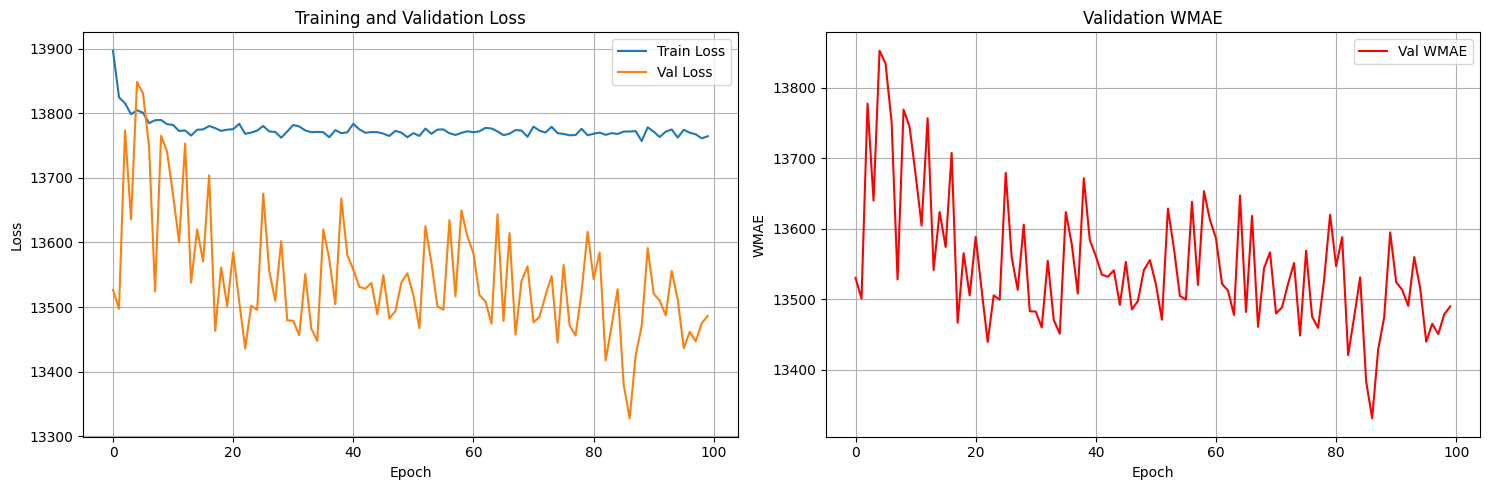

Model training completed and artifacts logged to wandb.


In [7]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, sales_mean, sales_std,
                 lr=1e-4, num_epochs=100, use_wmae_loss=True):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.sales_mean = sales_mean
        self.sales_std = sales_std
        self.lr = lr
        self.num_epochs = num_epochs
        self.use_wmae_loss = use_wmae_loss
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []
        self.val_wmaes = []
        self.best_wmae = float('inf')
        self.best_epoch = 0
        self.best_model_state = None

    def _wmae_loss(self, predictions, targets, weights):
        abs_errors = torch.abs(predictions - targets)
        weighted_errors = weights * abs_errors
        return torch.sum(weighted_errors) / torch.sum(weights)

    def _validate(self):
        self.model.eval()
        running_val_loss = 0.0
        val_samples = 0
        all_preds = []
        all_targets = []
        all_weights = []

        with torch.no_grad():
            for sequences, targets, weights in self.val_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                weights = weights.to(self.device)
                outputs = self.model(sequences)
                if outputs.dim() > 1:
                    if outputs.shape[1] == 1:
                        outputs = outputs.squeeze(1)
                    else:
                        outputs = outputs[:, 0]
                if self.use_wmae_loss:
                    loss = self._wmae_loss(outputs, targets, weights)
                else:
                    loss = self.criterion(outputs, targets)
                running_val_loss += loss.item() * sequences.size(0)
                val_samples += sequences.size(0)
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_weights.extend(weights.cpu().numpy())

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        all_weights = np.array(all_weights)
        val_loss = running_val_loss / val_samples
        val_wmae = self._calculate_wmae(all_preds, all_targets, all_weights)
        return val_loss, val_wmae

    def _calculate_wmae(self, predictions, targets, weights):
        if len(predictions) != len(targets) or len(predictions) != len(weights):
            min_len = min(len(predictions), len(targets), len(weights))
            predictions = predictions[:min_len]
            targets = targets[:min_len]
            weights = weights[:min_len]
        abs_errors = np.abs(predictions - targets)
        if np.sum(weights) == 0:
            return np.mean(abs_errors)
        return np.sum(weights * abs_errors) / np.sum(weights)

    def train(self):
        print(f"Starting training for {self.num_epochs} epochs...")
        for epoch in range(self.num_epochs):
            self.model.train()
            running_train_loss = 0.0
            train_samples = 0
            for sequences, targets, weights in self.train_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                weights = weights.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(sequences)
                if outputs.dim() > 1:
                    if outputs.shape[1] == 1:
                        outputs = outputs.squeeze(1)
                    else:
                        outputs = outputs[:, 0]
                if self.use_wmae_loss:
                    loss = self._wmae_loss(outputs, targets, weights)
                else:
                    loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_train_loss += loss.item() * sequences.size(0)
                train_samples += sequences.size(0)

            val_loss, val_wmae = self._validate()
            epoch_train_loss = running_train_loss / train_samples
            self.train_losses.append(epoch_train_loss)
            self.val_losses.append(val_loss)
            self.val_wmaes.append(val_wmae)

            if val_wmae < self.best_wmae:
                self.best_wmae = val_wmae
                self.best_epoch = epoch
                self.best_model_state = self.model.state_dict().copy()

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": epoch_train_loss,
                "val_loss": val_loss,
                "val_wmae": val_wmae
            })

            print(f"Epoch {epoch:3d}: Train Loss: {epoch_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val WMAE: {val_wmae:.4f}")

        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
        print(f"Training completed! Best WMAE: {self.best_wmae:.4f} at epoch {self.best_epoch}")

        # Log final metrics to wandb
        wandb.log({
            "best_wmae": self.best_wmae,
            "best_epoch": self.best_epoch,
            "final_val_wmae": self.val_wmaes[-1],
            "final_train_loss": self.train_losses[-1],
            "final_val_loss": self.val_losses[-1]
        })

    def plot_losses(self, save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(self.val_wmaes, label='Val WMAE', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('WMAE')
        ax2.set_title('Validation WMAE')
        ax2.legend()
        ax2.grid(True)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            wandb.log_artifact(save_path, name='loss_plot', type='plot')
        plt.show()

# Initialize and train model
num_features = train_sequences_scaled.shape[-1]
model = NBeatsNet(
    input_size=lookback_window,
    num_features=num_features,
    forecast_size=1,
    stacks=2,
    blocks_per_stack=3,
    layers=4,
    layer_size=512,
    theta_size=32
)

trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    sales_mean=train_targets.mean(),
    sales_std=train_targets.std(),
    lr=1e-4,
    num_epochs=100,
    use_wmae_loss=True
)

# Train the model
trainer.train()

# Save and log loss plot
plot_path = "/content/loss_plot.png"
trainer.plot_losses(save_path=plot_path)

# Log model artifact
torch.save(trainer.model.state_dict(), "/content/nbeats_model.pth")
wandb.log_artifact("/content/nbeats_model.pth", name='nbeats_model', type='model')

print("Model training completed and artifacts logged to wandb.")